# Face Morphing

In [55]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.spatial import tsearch
from skimage.draw import polygon
import cv2
import os
from IPython.display import HTML

In [60]:
# get face points
def setCorrespondence(im1, im2, n):
    matplotlib.use('tkagg')
    
    plt.imshow(im1)
    a_points = plt.ginput(n)
    plt.close
    
    plt.imshow(im2)
    b_points = plt.ginput(n)
    plt.close
    
    return np.array(a_points), np.array(b_points)

# average shape of two points at some alpha
def average_shape(pointsA, pointsB, alpha):
    result = []
    
    for i in range(len(pointsA)):
        x = alpha * pointsA[i][0] + (1 - alpha) * pointsB[i][0]
        y = alpha * pointsA[i][1] + (1 - alpha) * pointsB[i][1]
        result.append([x, y])

    return np.array(result)


def computeAffine(tri1_pts, tri2_pts):
    A = np.matrix([tri1_pts[:,0], tri1_pts[:, 1], [1, 1, 1]])
    B = np.matrix([tri2_pts[:,0], tri2_pts[:, 1], [1, 1, 1]])
    return B * np.linalg.inv(A)


def inverseMask(maskIn, im, src_tri, target_tri):
    a = computeAffine(src_tri, target_tri)

    mask = maskIn.copy()
    mask[0] = maskIn[0]
    mask[1] = maskIn[1]

    affined = (np.linalg.inv(a) * mask).astype(np.int)
    c, r, _ = affined

    mask = mask.astype(np.int)
    final = np.zeros_like(im)
    final[mask[1], mask[0]] = im[r, c]
    return final


def morph(im1, im2, im1_pts, im2_pts, warp_frac, dissolve_frac):
    avgpts = average_shape(im1_pts, im2_pts, warp_frac)
    triangles = Delaunay(avgpts)
    
    final = np.zeros_like(im1).astype(np.float)
    for triangle in triangles.simplices:
        target = avgpts[triangle]
        maskShape = (im1.shape[1], im1.shape[0], im1.shape[2])
        maskPoints = polygon(target[:,0], target[:,1], shape=maskShape)
        target_mask = np.vstack([maskPoints, np.ones(len(maskPoints[0]))])
        
        orig = im1_pts[triangle]
        part = warp_frac * inverseMask(target_mask, im1, orig, target)
        
        orig2 = im2_pts[triangle]
        part += (1-warp_frac) * inverseMask(target_mask, im2, orig2, target)
        final += part
        
    final[final>1] = 1
    return final

## Defining Correspondences

In [3]:
my_face = plt.imread('tushar.png')
leo_face = plt.imread('leo.png')
pts1, pts2 = setCorrespondence(my_face, leo_face, 30)

## Computing the Midway Face

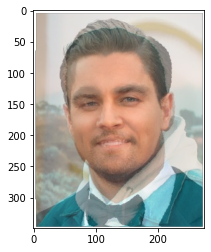

In [61]:
final = morph(my_face, leo_face, pts1, pts2, 0.5, 0.5)
%matplotlib inline
plt.imshow(final)

## Morph Sequence

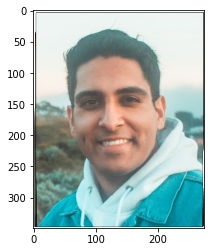

In [6]:
for i in range(46):
    alpha = (1.0/45.0) * i
    img = morph(my_face, leo_face, pts1, pts2, alpha, alpha)
    plt.imshow(img)
    plt.savefig('morph_' + str(i) + '.png')

In [54]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/7IW5rrzTCSE" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Mean Face of a Population

In [7]:
def read_images():
    images = []
    asfs = []
    asf_points = []
    for file in os.listdir('data/'):
        if '.bmp' in file:
            img = plt.imread('data/'+file)
            images.append(img)
            asf = file[:-3] + 'asf'
            asfs.append(asf)
    for asf in asfs:
        f = open('data/' + asf)
        #print(f.read())
        lines = f.readlines()
        points = []
        height = images[0].shape[0]
        width = images[0].shape[1]
        for line in lines[16:74]:
            data = line.split(" \t")
            points.append((np.int(width * float(data[2])), np.int(height * float(data[3]))))
        points.append((0, 0))
        points.append((width, 0))
        points.append((0, height))
        points.append((width, height))
        asf_points.append(points)
    return images, np.array(asf_points)

In [8]:
pop_images, pop_points = read_images()

In [9]:
total = np.copy(pop_points[0])
for i in range(1, pop_points.shape[0]):
    total += pop_points[i]
avg_shape = total/pop_points.shape[0]

## Dane to Avg Face

Morphed

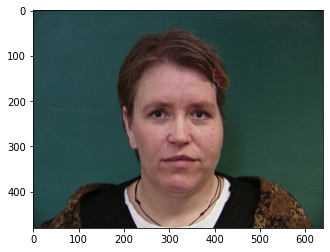

In [11]:
def warpToAvg(im, im_pts, avgpts, danes=True):
    triangles = Delaunay(avgpts)
    
    final = np.zeros_like(im).astype(np.float)
    for triangle in triangles.simplices:
        target = avgpts[triangle]
        maskShape = (im.shape[1], im.shape[0], im.shape[2])
        maskPoints = polygon(target[:,0], target[:,1], shape=maskShape)
        target_mask = np.vstack([maskPoints, np.ones(len(maskPoints[0]))])
        
        orig = im_pts[triangle]
        final_tri = inverseMask(target_mask, im, orig, target)
        final += final_tri
    if danes:
        final /= 255
    return final 
plt.imshow(warpToAvg(pop_images[0], pop_points[0], avg_shape))

Original

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bas

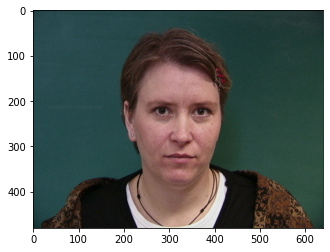

In [57]:
plt.imshow(pop_images[0])

Morphed

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bas

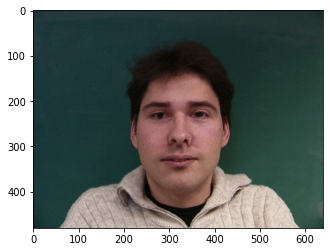

In [56]:
plt.imshow(warpToAvg(pop_images[1], pop_points[1], avg_shape))

Original

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bas

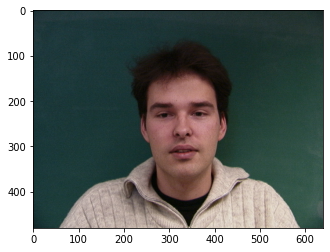

In [58]:
plt.imshow(pop_images[1])

In [12]:
popToMean = np.zeros((480,640,3,40))
for i in range(pop_points.shape[0]):
    popToMean[:,:,:,i] = warpToAvg(pop_images[i], pop_points[i], avg_shape) 

In [13]:
average_face = np.copy(popToMean[:,:,:,0])
for x in range(1,pop_points.shape[0]):
    average_face += popToMean[:,:,:,x]
average_face = average_face/pop_points.shape[0]

## Average Face

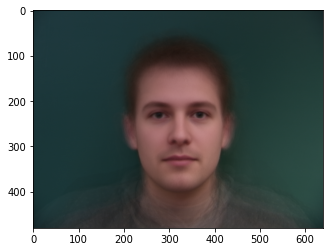

In [14]:
plt.imshow(average_face)

In [15]:
from align_image_code import align_images
matplotlib.use('tkagg')
a, b = align_images(average_face, my_face)

Please select 2 points in each image for alignment.


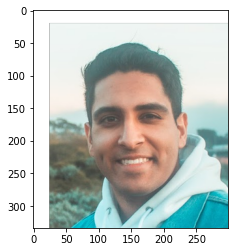

In [16]:
%matplotlib inline
plt.imshow(b)

<function matplotlib.pyplot.close(fig=None)>

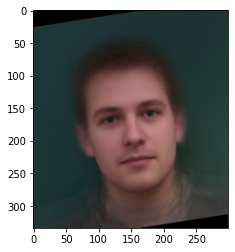

In [17]:
matplotlib.use('tkagg')
plt.imshow(a)
my_new_points = np.array(plt.ginput(30, timeout = 1000))
plt.close

## Average Face with My Geometry

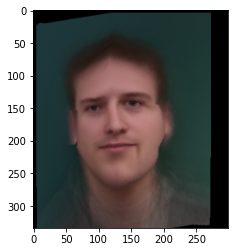

In [19]:
%matplotlib inline
plt.imshow(warpToAvg(a, my_new_points, pts1, False))

<function matplotlib.pyplot.close(fig=None)>

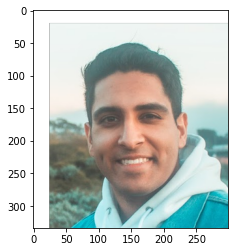

In [24]:
matplotlib.use('tkagg')
plt.imshow(b)
my_new_points2 = np.array(plt.ginput(30, timeout = 1000))
plt.close

## My Face with Avg Geometry

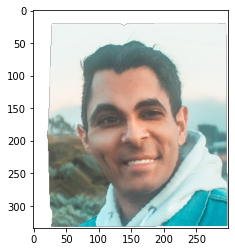

In [25]:
%matplotlib inline
plt.imshow(warpToAvg(b, my_new_points2, my_new_points, False))

## Caricatures

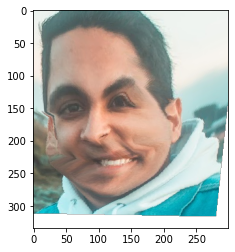

In [36]:
plt.imshow(warpToAvg(b, my_new_points2, my_new_points2 + 0.25*(my_new_points2 - avg_shape[:30,]), False))

## Bells and Whistles - Age Morph

In [47]:
my_face2 = plt.imread('tushar2.png')
my_face3 = plt.imread('tushar3.png')

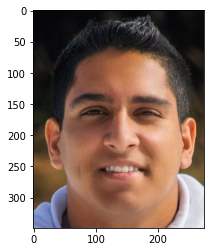

In [48]:
pts3, pts4 = setCorrespondence(my_face2, my_face3, 30)

In [50]:
points = [pts1, pts3, pts4]
ims = [my_face, my_face2, my_face3]

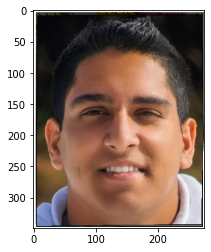

In [51]:
k = 0
for j in range(2):
    for i in range(46):
        alpha = (1.0/45.0) * i
        img = morph(ims[(j+1)], ims[j], points[(j+1)], points[j], alpha, alpha)
        plt.imshow(img)
        plt.savefig('ages_' + str(k) + '.png')
        k += 1

In [53]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/w-g17AM8fNM" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/Users/tusharchopra/anaconda3/envs/194/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
